In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

class myQagent:
    """
    A Q-learning agent for a single-agent environment.

    The agent learns to navigate from a starting state to a goal state
    by learning the optimal action to take in each state.

    The goal of the agent is to reach outside the building starting from any random state (room).

    Attributes:
        n_states (int): The total number of states.
        n_actions (int): The total number of possible actions.
        learning_rate (float): Alpha, the rate at which the agent learns.
        discount_factor (float): Gamma, the factor for future rewards.
        exploration_rate (float): Epsilon, the initial probability of choosing a random action.
        min_exploration_rate (float): The minimum value for the exploration rate.
        exploration_decay_rate (float): The rate at which epsilon decays.
        q_table (np.ndarray): A 2D array (states x actions) storing the Q-values.
    """
    def __init__(self, n_states, n_actions, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0):
        """Initializes the Q-learning agent."""
        self.n_states = n_states
        self.n_actions = n_actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.min_exploration_rate = 0.01
        self.exploration_decay_rate = 0.005

        # Q-table is now 2D: states rows, actions columns
        self.q_table = np.zeros((n_states, n_actions))

    def choose_action(self, state, reward_matrix):
        """
        Decides which action to take from a given state using an epsilon-greedy strategy.

        Args:
            state (int): The current state of the agent.
            reward_matrix (np.ndarray): The reward matrix to find valid actions.

        Returns:
            int: The index of the action chosen by the agent.
        """
        exploration_threshold = np.random.uniform(0, 1)

        if exploration_threshold < self.exploration_rate:
            # Exploration: Choose a random valid action from the current state.
            return np.random.choice(np.where(reward_matrix[state] != -1)[0]) # -1 for walls
        else:
            # Exploitation: Choose the action with the highest Q-value for the current state.
            return np.argmax(self.q_table[state])

    def update_q_table(self, state, action, reward, next_state):
        """
        Updates the Q-value for a given state-action pair.

        Args:
            state (int): The state where the action was taken.
            action (int): The action that was taken.
            reward (int): The reward received from the action.
            next_state (int): The state transitioned to after the action.
        """
        # The classic Q-learning formula:
        # Q(s, a) = Q(s, a) + alpha * (reward + gamma * max(Q(s', a')) - Q(s, a))
        old_value = self.q_table[state, action]
        next_max = np.max(self.q_table[next_state]) # The best Q-value for the next state

        new_value = old_value + self.learning_rate * (reward + self.discount_factor * next_max - old_value)
        self.q_table[state, action] = new_value

    def decay_exploration_rate(self, episode):
        """Reduces the exploration rate over time."""
        self.exploration_rate = self.min_exploration_rate + \
            (1.0 - self.min_exploration_rate) * np.exp(-self.exploration_decay_rate * episode)


In [45]:

def train_agent(reward_matrix, n_episodes=5000, goal_state=7):
    """
    Simulates the environment and trains the Q-learning agent.

    Args:
        reward_matrix (np.ndarray): The state-action reward matrix.
        n_episodes (int): The number of training trials.
        goal_state (int): The target state to reach.
        
    Returns:
        tuple: A tuple containing the trained agent, a list of rewards per episode,
               and a list of steps per episode.
    """
    n_states, n_actions = reward_matrix.shape
    agent = myQagent(n_states, n_actions)
    rewards_per_episode = []
    steps_per_episode = []

    print("--- Training Started ---")
    print(f"Total Episodes: {n_episodes}\n")

    # --- Training Loop ---
    for episode in range(n_episodes):
        
        state = np.random.randint(0, n_states)
        done = False
        total_reward = 0
        steps = 0
        
        while not done:
            action = agent.choose_action(state, reward_matrix)
            next_state = action
            reward = reward_matrix[state, action]
            
            total_reward += reward
            steps += 1
            
            agent.update_q_table(state, action, reward, next_state)
            state = next_state
            
            if state == goal_state:
                done = True

        rewards_per_episode.append(total_reward)
        steps_per_episode.append(steps)
        agent.decay_exploration_rate(episode)

        if (episode + 1) % 500 == 0:
            print(f"Episode {episode + 1}: Exploration rate = {agent.exploration_rate:.4f}")

    print("\n--- Training Finished ---")
    print("\nFinal Q-Table (State-Action Matrix):")
    print(agent.q_table.round(2))
        
    return agent, rewards_per_episode, steps_per_episode

def find_optimal_path(agent, start_state, goal_state, reward_matrix):
    """
    Uses the trained Q-table to find the optimal path from start to goal.
    """
    if agent is None:
        print("\nPathfinding skipped because the agent was not trained.")
        return

    print(f"\n--- Finding Optimal Path from State {start_state} to {goal_state} ---")
    path = [start_state]
    current_state = start_state
    
    max_steps = reward_matrix.shape[0] * 2 
    steps = 0

    while current_state != goal_state and steps < max_steps:
        action = np.argmax(agent.q_table[current_state])
        current_state = action
        path.append(current_state)
        steps += 1

    if current_state == goal_state:
        print(f"Optimal Path Found: {' -> '.join(map(str, path))}")
    else:
        print("Could not find a path to the goal state.")

def print_environment_text(reward_matrix):
    """
    Prints the environment's state connections in a textual format.
    """
    print("--- Building Layout (State Connections) ---")
    n_states = reward_matrix.shape[0]
    for i in range(n_states):
        for j in range(n_states):
            if reward_matrix[i, j] != -1:
                print(f"  Room {i} -> Room {j} (Reward: {int(reward_matrix[i, j])})")
    print("-" * 42)

def plot_metrics(rewards_per_episode, steps_per_episode):
    """
    Plots the cumulative reward and steps per episode.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

    # Plotting Cumulative Reward
    ax1.plot(rewards_per_episode)
    ax1.set_title('Cumulative Reward per Episode')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.grid(True)
    
    # Plotting Steps per Episode
    ax2.plot(steps_per_episode)
    ax2.set_title('Steps per Episode')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Steps Taken')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()



--- Building Layout (State Connections) ---
  Room 0 -> Room 4 (Reward: 0)
  Room 0 -> Room 6 (Reward: 20)
  Room 1 -> Room 3 (Reward: 0)
  Room 1 -> Room 5 (Reward: 20)
  Room 2 -> Room 3 (Reward: 0)
  Room 3 -> Room 1 (Reward: 0)
  Room 3 -> Room 2 (Reward: 0)
  Room 3 -> Room 4 (Reward: 0)
  Room 4 -> Room 0 (Reward: 0)
  Room 4 -> Room 3 (Reward: 0)
  Room 4 -> Room 5 (Reward: 20)
  Room 5 -> Room 1 (Reward: 0)
  Room 5 -> Room 4 (Reward: 0)
  Room 5 -> Room 6 (Reward: 20)
  Room 5 -> Room 7 (Reward: 100)
  Room 6 -> Room 0 (Reward: 0)
  Room 6 -> Room 5 (Reward: 20)
  Room 6 -> Room 7 (Reward: 100)
  Room 7 -> Room 7 (Reward: 100)
------------------------------------------
--- Training Started ---
Total Episodes: 10000

Episode 500: Exploration rate = 0.0917
Episode 1000: Exploration rate = 0.0167
Episode 1500: Exploration rate = 0.0106
Episode 2000: Exploration rate = 0.0100
Episode 2500: Exploration rate = 0.0100
Episode 3000: Exploration rate = 0.0100
Episode 3500: Exploration 

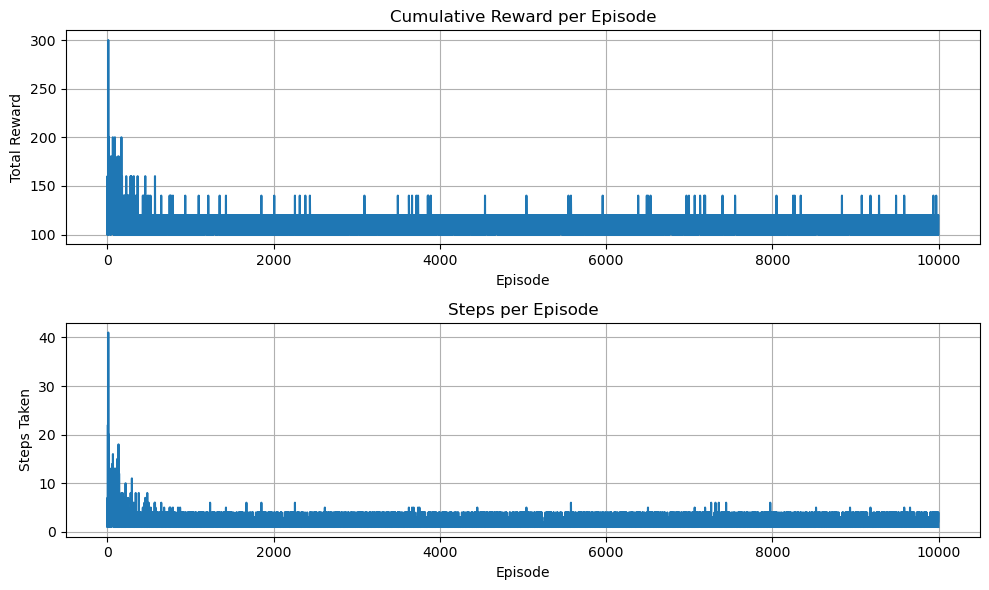

In [ ]:

if __name__ == "__main__":
    # Define environment parameters
    GOAL_STATE = 7
    START_STATE = 2 # Example start state
    
    # Define the environment directly as an 8x8 reward matrix.
    # Rows are the current state, columns are the next state (action).
    # -1 represents a wall (invalid move).
    
    reward_matrix = np.array([
        # Actions (Next State)
        # 0   1    2    3    4    5    6     7
        [-1, -1,  -1,  -1,   0,  -1,  20,   -1], # State 0
        [-1, -1,  -1,   0,  -1,  20,  -1,   -1], # State 1
        [-1, -1,  -1,   0,  -1,  -1,  -1,   -1], # State 2
        [-1,  0,   0,  -1,   0,  -1,  -1,   -1], # State 3
        [ 0, -1,  -1,   0,  -1,  20,  -1,   -1], # State 4
        [-1,  0,  -1,  -1,   0,  -1,  20,  100], # State 5
        [ 0, -1,  -1,  -1,  -1,  20,  -1,  100], # State 6
        [-1, -1,  -1,  -1,  -1,  -1,  -1,  100]  # State 7
    ])

    # Visualize the environment in text format before training
    print_environment_text(reward_matrix)
    
    # Train the agent
    trained_agent, episode_rewards, episode_steps = train_agent(reward_matrix, n_episodes=10000, goal_state=GOAL_STATE)
    
    # Find and print the optimal path
    find_optimal_path(trained_agent, START_STATE, GOAL_STATE, reward_matrix)
    
    # Plot the learning progress
    plot_metrics(episode_rewards, episode_steps)
